# Project 2: Structure from Motion

Mo Zhou <mzhou32@jhu.edu>

Implement the factorization approach for structure from motion for orthographic camera case [1].

Dataset: Castle Sequence, Medusa Head 

Reference
[1] C. Tomasi and T. Kanade, "Shape and motion from image streams under orthography-- a
factorization method," International Journal of Computer Vision, 9(2):137--154, 1992.

Submission Guidelines
Report detailing main implementation steps, a critique on the performance of Tomasi-Kanade algorithm and failure modes, reasons for poor/superlative performance.

Feature Point Tracking
Feel free to use any feature point trackers. You are free to use any code for feature point
tracking available online. KLT (Shi, Tomasi "Good Features to Track") is a popular tracker.
Code for that is available in C/C++ as a part of the OpenCV libraries. Matlab may be available online.

## 1: Feature point extraction

In this part, we extract feature points using KLT through OpenCV library.
We first load the medusa video, extract feature points, and then store
the feature points in the `point_stream` list. It's length is 434.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load dataset
vid1 = cv2.VideoCapture('medusa.dv');

# parametrs for shitomasi corner detection
Ncorner = 128
feature_params = dict(maxCorners = Ncorner,
                     qualityLevel=0.3,
                     minDistance=7,
                     blockSize=7)

# parameters fro lucss kanade optical flow
lk_params = dict(winSize=(15,15),
                maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS |
                          cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# random colors
color = np.random.randint(0, 255, (Ncorner, 3))
# take first frame and find corners in it
ret, old_frame = vid1.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
# create mask for plotting
mask = np.zeros_like(old_frame)
point_stream = []
while ret:
    ret, frame = vid1.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, 
                                           frame_gray, p0, None, **lk_params)
    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    point_stream.append(p0)
print(len(point_stream))

434


### 1.1 sanity check for feature point extraction

We draw the feature points from the last frame as a scatter plot.

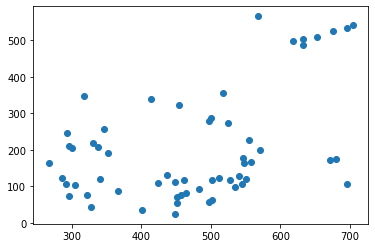

In [20]:
x = point_stream[-1].reshape([-1, 2])
plt.scatter(x[:,0], x[:,1])

## 2. Paper implementation

Data is organized into matrices. Preprocessing is done following the Section 3 of the paper. The algorithm is implemented following Section 3.4 of the paper.

In [21]:
# 2.1 organize input data
pts = np.stack([x for x in point_stream if x.shape[0] == Ncorner])
pts = pts.reshape(-1, Ncorner, 2)
print(pts.shape) # (F, P, (u, v))
U = pts[:, :, 0]
V = pts[:, :, 1]
print(U.shape, V.shape)
W = np.vstack([U, V])  # measurement matrix
print(W.shape)

(240, 128, 2)
(240, 128) (240, 128)
(480, 128)


In [22]:
# 2.2 pre-process data: registered measurement matrix.
tildeU = U - U.mean(axis=1).reshape(-1, 1)
tildeV = V - V.mean(axis=1).reshape(-1, 1)
tildeW = np.vstack([tildeU, tildeV])
print(tildeW.shape)
# --> this is the input to the factorization method

(480, 128)


In [23]:
# (1) compute the SVD for \tilde{W}
O1, Sigma, O2 = np.linalg.svd(tildeW)
print(O1.shape, Sigma.shape, O2.shape)

(480, 480) (128,) (128, 128)


In [24]:
# (2) define \hat{R} and \hat{S}
O1prime = O1[:,0:3]; print(O1prime.shape)
O2prime = O2[0:3,:]; print(O2prime.shape)
hatR = O1prime @ np.diag(np.sqrt(Sigma[:3])); print(hatR.shape)
hatS = np.diag(np.sqrt(Sigma[:3])) @ O2prime; print(hatS.shape)

(480, 3)
(3, 128)
(480, 3)
(3, 128)


In [42]:
# (3) compute matrix Q in Eq.15 by imposing the metric constraints in Eq.16
NF = hatR.shape[0]//2

# Is = hatR[:NF, :]
# Js = hatR[NF:2*NF, :]
# def gfun(a, b):
#     return np.array([a[0]*b[0], a[0]*b[1]+a[1]*b[0], a[0]*b[2]+a[2]*b[0],
#                      a[1]*b[1], a[1]*b[2]+a[2]*b[1], a[2]*b[2]])
# G = np.zeros((3*NF, 6))
# for i in range(3*NF):
#     if i < NF:
#         G[i, :] = gfun(Is[i, :], Is[i, :])
#     elif i < NF*2:
#         G[i, :] = gfun(Js[i%(NF), :], Js[i%(NF), :])
#     else:
#         G[i, :] = gfun(Is[i%(2*NF), :], Js[i%(2*NF), :])
# c = np.vstack([np.ones((2*NF, 1)), np.zeros((NF, 1))])
# tU, tS, tV = np.linalg.svd(G)
# hatl = tU.T @ c;
# y = [hatl[0]/np.diag(tS)[0,0], hatl[1]/np.diag(tS)[1,1],
#          hatl[2]/np.diag(tS)[2,2], hatl[3]/np.diag(tS)[3,3],
#      hatl[4]/np.diag(tS)[4,4], hatl[5]/np.diag(tS)[5,5]]
# l = tV @ y;
# L = np.array([l[0], l[1], l[2], l[1], l[3], l[4], l[2], l[4], l[5]])
# L = L.reshape((3,3))
# print(L)
# Q = np.linalg.cholesky(L)


R_cap_i = hatR[:NF, :]
R_cap_j = hatR[NF:2*NF, :]
A = np.zeros((2*NF, 6))
for i in range(NF):
    A[2 * i, 0] = (R_cap_i[i, 0] ** 2) - (R_cap_j[i, 0] ** 2)
    A[2 * i, 1] = 2 * ((R_cap_i[i, 0] * R_cap_i[i, 1]) - (R_cap_j[i, 0] * R_cap_j[i, 1]))
    A[2 * i, 2] = 2 * ((R_cap_i[i, 0] * R_cap_i[i, 2]) - (R_cap_j[i, 0] * R_cap_j[i, 2]))
    A[2 * i, 3] = (R_cap_i[i, 1] ** 2) - (R_cap_j[i, 1] ** 2)
    A[2 * i, 5] = (R_cap_i[i, 2] ** 2) - (R_cap_j[i, 2] ** 2)
    A[2 * i, 4] = 2 * ((R_cap_i[i, 2] * R_cap_i[i, 1]) - (R_cap_j[i, 2] * R_cap_j[i, 1]))
    A[2 * i + 1, 0] = R_cap_i[i, 0] * R_cap_j[i, 0]
    A[2 * i + 1, 1] = R_cap_i[i, 1] * R_cap_j[i, 0] + R_cap_i[i, 0] * R_cap_j[i, 1]
    A[2 * i + 1, 2] = R_cap_i[i, 2] * R_cap_j[i, 0] + R_cap_i[i, 0] * R_cap_j[i, 2]
    A[2 * i + 1, 3] = R_cap_i[i, 1] * R_cap_j[i, 1]
    A[2 * i + 1, 4] = R_cap_i[i, 2] * R_cap_j[i, 1] + R_cap_i[i, 1] * R_cap_j[i, 2]
    A[2 * i + 1, 5] = R_cap_i[i, 2] * R_cap_j[i, 2]
tmpU, tmpS, tmpV = np.linalg.svd(A)
QQT = np.zeros((3,3))
v = tmpV[-1,:]
QQT[0, 0] = v[0]
QQT[1, 1] = v[3]
QQT[2, 2] = v[5]
QQT[0, 1] = v[1]
QQT[1, 0] = v[1]
QQT[0, 2] = v[2]
QQT[2, 0] = v[2]
QQT[2, 1] = v[4]
QQT[1, 2] = v[4]
QQT = np.abs(QQT)
print(QQT)
tmpU, tmpS, tmpV = np.linalg.svd(QQT)
print(tmpS)
Q = np.linalg.cholesky(QQT)
print(Q)

[[0.66253672 0.00915788 0.00133546]
 [0.00915788 0.23718774 0.02778824]
 [0.00133546 0.02778824 0.70987973]]
[0.71157918 0.66265759 0.23536742]
[[0.81396359 0.         0.        ]
 [0.01125097 0.48688926 0.        ]
 [0.00164069 0.05703511 0.84060932]]


In [43]:
# (4) compute the rotation matrix R and the shape matrix S
Qinv = np.linalg.inv(Q)
R = hatR @ Q
S = Qinv @ hatS

In [44]:
# (5) create point cloud
X = S[0,:]
Y = S[1,:]
Z = S[2,:]
pc = np.zeros((X.shape[0], 3))
pc[:, 0] = X
pc[:, 1] = Y
pc[:, 2] = Z

import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)
o3d.io.write_point_cloud("pc.ply", pcd)
pcd_load = o3d.io.read_point_cloud("pc.ply")
o3d.visualization.draw_geometries([pcd_load])

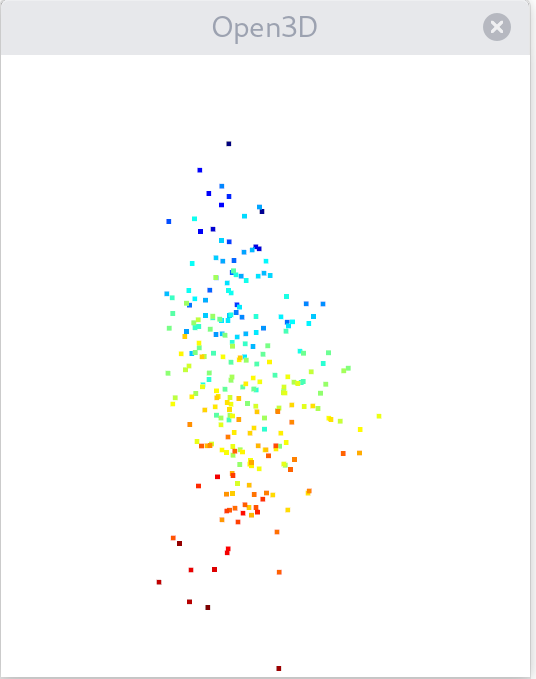

# Castle

We use the same code as that for the medusa video. Only the part for loading data has been changed. Number of corners is set as 256.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load dataset
vid1 = cv2.imread('castle/castle.000.jpg');

# parametrs for shitomasi corner detection
Ncorner = 256
feature_params = dict(maxCorners = Ncorner,
                     qualityLevel=0.3,
                     minDistance=7,
                     blockSize=7)

# parameters fro lucss kanade optical flow
lk_params = dict(winSize=(15,15),
                maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS |
                          cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# random colors
color = np.random.randint(0, 255, (Ncorner, 3))
# take first frame and find corners in it
old_frame = vid1
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
# create mask for plotting
mask = np.zeros_like(old_frame)
point_stream = []
for i in range(1, 27+1):
    frame = cv2.imread(f'castle/castle.{i:03d}.jpg')
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, 
                                           frame_gray, p0, None, **lk_params)
    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    point_stream.append(p0)
print(len(point_stream))

27


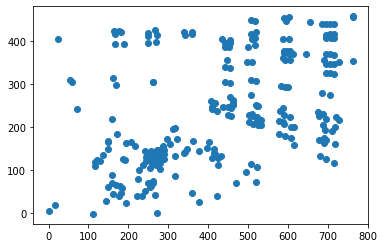

In [17]:
x = point_stream[-1].reshape([-1, 2])
plt.scatter(x[:,0], x[:,1])

In [18]:
# 2.1 organize input data
pts = np.stack([x for x in point_stream if x.shape[0] == Ncorner])
pts = pts.reshape(-1, Ncorner, 2)
print(pts.shape) # (F, P, (u, v))
U = pts[:, :, 0]
V = pts[:, :, 1]
print(U.shape, V.shape)
W = np.vstack([U, V])  # measurement matrix
print(W.shape)

(5, 256, 2)
(5, 256) (5, 256)
(10, 256)


In [19]:
# 2.2 pre-process data: registered measurement matrix.
tildeU = U - U.mean(axis=1).reshape(-1, 1)
tildeV = V - V.mean(axis=1).reshape(-1, 1)
tildeW = np.vstack([tildeU, tildeV])
print(tildeW.shape)
# --> this is the input to the factorization method

(10, 256)


In [20]:
# (1) compute the SVD for \tilde{W}
O1, Sigma, O2 = np.linalg.svd(tildeW)
print(O1.shape, Sigma.shape, O2.shape)

(10, 10) (10,) (256, 256)


In [21]:
# (2) define \hat{R} and \hat{S}
O1prime = O1[:,0:3]; print(O1prime.shape)
O2prime = O2[0:3,:]; print(O2prime.shape)
hatR = O1prime @ np.diag(np.sqrt(Sigma[:3])); print(hatR.shape)
hatS = np.diag(np.sqrt(Sigma[:3])) @ O2prime; print(hatS.shape)

(10, 3)
(3, 256)
(10, 3)
(3, 256)


In [25]:
# (3) compute matrix Q in Eq.15 by imposing the metric constraints in Eq.16
NF = hatR.shape[0]//2
R_cap_i = hatR[:NF, :]
R_cap_j = hatR[NF:2*NF, :]
A = np.zeros((2*NF, 6))
for i in range(NF):
    A[2 * i, 0] = (R_cap_i[i, 0] ** 2) - (R_cap_j[i, 0] ** 2)
    A[2 * i, 1] = 2 * ((R_cap_i[i, 0] * R_cap_i[i, 1]) - (R_cap_j[i, 0] * R_cap_j[i, 1]))
    A[2 * i, 2] = 2 * ((R_cap_i[i, 0] * R_cap_i[i, 2]) - (R_cap_j[i, 0] * R_cap_j[i, 2]))
    A[2 * i, 3] = (R_cap_i[i, 1] ** 2) - (R_cap_j[i, 1] ** 2)
    A[2 * i, 5] = (R_cap_i[i, 2] ** 2) - (R_cap_j[i, 2] ** 2)
    A[2 * i, 4] = 2 * ((R_cap_i[i, 2] * R_cap_i[i, 1]) - (R_cap_j[i, 2] * R_cap_j[i, 1]))
    A[2 * i + 1, 0] = R_cap_i[i, 0] * R_cap_j[i, 0]
    A[2 * i + 1, 1] = R_cap_i[i, 1] * R_cap_j[i, 0] + R_cap_i[i, 0] * R_cap_j[i, 1]
    A[2 * i + 1, 2] = R_cap_i[i, 2] * R_cap_j[i, 0] + R_cap_i[i, 0] * R_cap_j[i, 2]
    A[2 * i + 1, 3] = R_cap_i[i, 1] * R_cap_j[i, 1]
    A[2 * i + 1, 4] = R_cap_i[i, 2] * R_cap_j[i, 1] + R_cap_i[i, 1] * R_cap_j[i, 2]
    A[2 * i + 1, 5] = R_cap_i[i, 2] * R_cap_j[i, 2]
tmpU, tmpS, tmpV = np.linalg.svd(A)
QQT = np.zeros((3,3))
v = tmpV[-1,:]
QQT[0, 0] = v[0]
QQT[1, 1] = v[3]
QQT[2, 2] = v[5]
QQT[0, 1] = v[1]
QQT[1, 0] = v[1]
QQT[0, 2] = v[2]
QQT[2, 0] = v[2]
QQT[2, 1] = v[4]
QQT[1, 2] = v[4]
#QQT = np.abs(QQT)
print(QQT)
tmpU, tmpS, tmpV = np.linalg.svd(QQT)
print(tmpS)
#Q = np.linalg.cholesky(QQT)
Q = tmpU @ np.diag(tmpS)**(1/2)
print(Q)

[[ 0.38677718 -0.50670773  0.10564281]
 [-0.50670773 -0.04527938 -0.71004978]
 [ 0.10564281 -0.71004978 -0.2761691 ]]
[0.94915272 0.9321265  0.04830249]
[[-0.63250528  0.19798428  0.16097213]
 [ 0.61618021  0.65694294  0.08134253]
 [-0.41159657  0.67923096 -0.12559403]]


In [26]:
# (4) compute the rotation matrix R and the shape matrix S
Qinv = np.linalg.inv(Q)
R = hatR @ Q
S = Qinv @ hatS

In [28]:
# (5) create point cloud
X = S[0,:]
Y = S[1,:]
Z = S[2,:]
pc = np.zeros((X.shape[0], 3))
pc[:, 0] = X
pc[:, 1] = Y
pc[:, 2] = Z

import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)
o3d.io.write_point_cloud("pc.ply", pcd)
pcd_load = o3d.io.read_point_cloud("pc.ply")
o3d.visualization.draw_geometries([pcd_load])

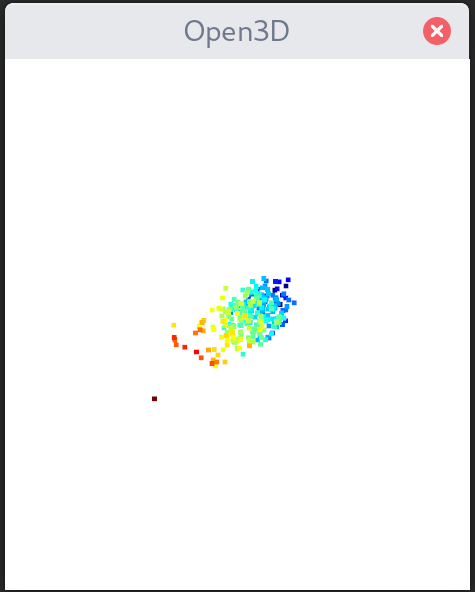

# References

1. https://stackoverflow.com/questions/49811072/klt-tracker-in-opencv-not-working-properly-with-python (borrowed the KLT example)
2. https://github.com/aj161198/Structure_From_Motion/blob/master/reconstruct.py (borrowed the solution to Q)
3. https://github.com/akanazawa/Structure-from-Motion/blob/master/do_factorization.m (borrowed solution to Q)